# Goal

You need to estimate the total flow of oil, gas, and water through a choke valve. The total flow rate is labeled `QTOT`. You should use all measurements that may explain the total flow. Awesome Corp has already prepared these for you in a dataset (no further preprocessing is required). The measurements (features) are labeled as follows:
- `CHK`: choke opening - a number in [0, 1], 1 meaning fully open and 0 meaning closed
- `PWH`: pressure upstream the choke (scaled)
- `PDC`: pressure downstream the choke (scaled)
- `TWH`: temperature upstream the choke (scaled)
- `FGAS`: fraction of gas to total flow - a number in [0,1]
- `FOIL`: fraction of water to total flow - a number in [0,1]

The location of the sensors are shown in the figure below.

<img src="well_sensors.png">

### Wait! There is one issue. The customer does not have a model for the total flow rate...

A simple choke model for water flow is:
$$QTOT = C_v(CHK) \sqrt{\frac{2(PWH - PDC)}{\rho}}$$
where $C_v(CHK)$ gives the cross-sectional area as a function of choke opening `CHK`.

Unfortunately, there are complications that prevent us from using this model:

1. We do not know what the correct equations are for multi-phase flow. For example, we expect gas expansions to be a factor. This factor is likely dependent on the temperature `TWH` and the amount of gas `FGAS`. Viscosity is probably a factor too, and that would depend on `FOIL`.
2. We do not know the form of the choke $C_v$-curve.

[Head scratch] Perhaps we can use a deep learning algorithm to learn a good representation of the data? Let us try to use all the available measurements to model `QTOT` using a neural network:
$$QTOT = f_{\theta}(CHK, PWH, PDC, TWH, FGAS, FOIL)$$

Let's get to work!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam


# Dataset

In [2]:
df = pd.read_csv('well_data.csv', index_col=0)
df

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
0,0.540,0.542755,0.211586,0.594760,0.138882,0.861118,32.358228
1,0.540,0.542755,0.211586,0.594760,0.142222,0.857774,32.940225
2,0.894,0.458000,0.222654,0.616555,0.144697,0.855303,48.633042
3,0.894,0.452311,0.222556,0.609029,0.144938,0.855056,48.065657
4,0.894,0.443485,0.221839,0.602488,0.144187,0.855807,47.096656
...,...,...,...,...,...,...,...
3094,0.534,0.462606,0.215561,0.592627,0.128039,0.826061,28.108285
3095,0.534,0.462854,0.216331,0.589506,0.127935,0.825378,28.119254
3096,0.534,0.463855,0.239411,0.594895,0.127857,0.824711,27.875849
3097,0.415,0.498174,0.234317,0.581882,0.129256,0.833875,18.412828


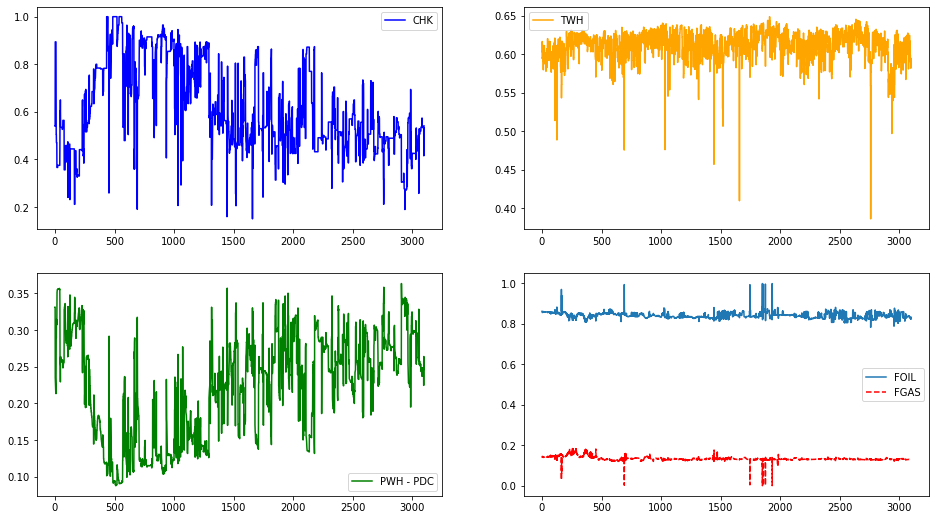

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Choke valve opening
ax[0, 0].plot(df['CHK'], label='CHK', color="blue")
ax[0, 0].legend()

# Total floqw through choke valve
ax[0, 1].plot(df['TWH'], label='TWH', color='orange')
ax[0, 1].legend()

# Diff pressure over choke valve
ax[1, 0].plot(df['PWH'] - df['PDC'], label='PWH - PDC', color='green')
ax[1, 0].legend()

# Fractions
ax[1, 1].plot(df['FOIL'], label='FOIL')
ax[1, 1].plot(df['FGAS'], '--r', label='FGAS')
ax[1, 1].legend()

In [4]:
df.corr()

,CHK,PWH,PDC,TWH,FGAS,FOIL,QTOT
CHK,1.000000,-0.963694,0.706279,0.285622,0.091705,-0.087384,0.935945
PWH,-0.963694,1.000000,-0.690669,-0.262040,-0.053365,0.097010,-0.889464
PDC,0.706279,-0.690669,1.000000,0.086445,-0.071751,-0.103538,0.647044
TWH,0.285622,-0.262040,0.086445,1.000000,0.070121,-0.096992,0.372099
FGAS,0.091705,-0.053365,-0.071751,0.070121,1.000000,-0.375864,0.189640
FOIL,-0.087384,0.097010,-0.103538,-0.096992,-0.375864,1.000000,-0.096468
QTOT,0.935945,-0.889464,0.647044,0.372099,0.189640,-0.096468,1.000000


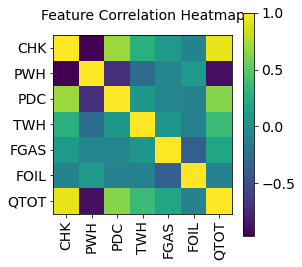

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

## Split into training, validation and test data.

### Test data

In [6]:
test_set = df[2000:2500]

x_test = test_set.drop(columns='QTOT')
y_test = test_set[['QTOT']]

### Validation data

In [7]:
#train_val_set = df.copy().drop(test_set.index) 
train_val_set = df.iloc[0:250]

val_set = train_val_set.sample(frac=0.1, replace=False)

x_val = val_set.drop(columns='QTOT')
y_val = val_set[['QTOT']]

### Training data

In [8]:
train_set = train_val_set.copy().drop(val_set.index)

x_train = train_set.drop(columns='QTOT')
y_train = train_set[['QTOT']]

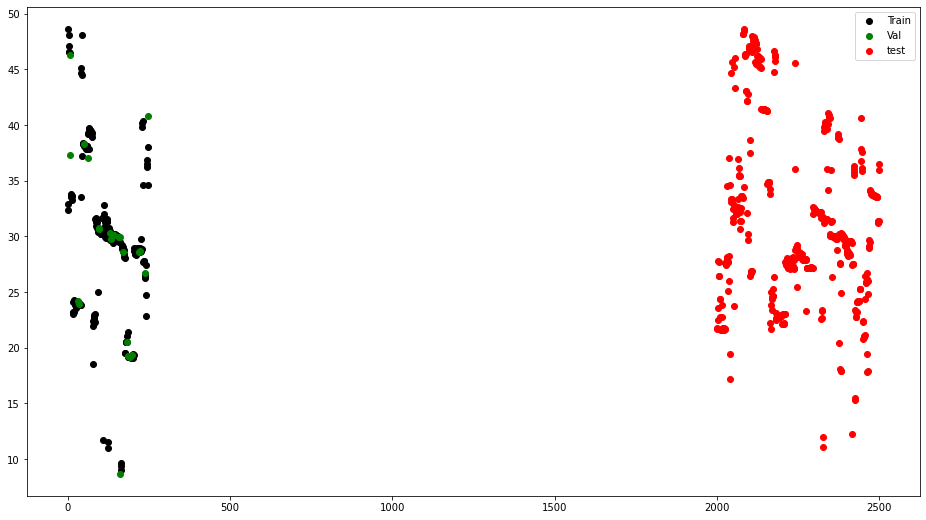

In [9]:
plt.figure(figsize=(16,9))
plt.scatter(y_train.index, y_train.values, color='black', label='Train')
plt.scatter(val_set.index, val_set['QTOT'], color='green', label='Val')
plt.scatter(y_test.index, y_test.values, color='red', label='test')
plt.legend()

# Simple model

In [10]:
from keras import regularizers

input_layer_size = x_train.columns.size

model = keras.Sequential()
model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,259
Trainable params: 9,259
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [13]:
history = model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10,verbose=2)

Epoch 1/200
23/23 - 0s - loss: 904.6927 - val_loss: 843.2440
Epoch 2/200
23/23 - 0s - loss: 840.9204 - val_loss: 745.4878
Epoch 3/200
23/23 - 0s - loss: 685.2473 - val_loss: 523.3756
Epoch 4/200
23/23 - 0s - loss: 392.7191 - val_loss: 188.3589
Epoch 5/200
23/23 - 0s - loss: 100.2131 - val_loss: 38.4010
Epoch 6/200
23/23 - 0s - loss: 40.4032 - val_loss: 39.7522
Epoch 7/200
23/23 - 0s - loss: 38.0061 - val_loss: 37.3992
Epoch 8/200
23/23 - 0s - loss: 38.4910 - val_loss: 37.5029
Epoch 9/200
23/23 - 0s - loss: 37.5840 - val_loss: 36.7986
Epoch 10/200
23/23 - 0s - loss: 37.4897 - val_loss: 36.3827
Epoch 11/200
23/23 - 0s - loss: 36.8603 - val_loss: 36.1996
Epoch 12/200
23/23 - 0s - loss: 36.5811 - val_loss: 35.3393
Epoch 13/200
23/23 - 0s - loss: 36.0538 - val_loss: 34.7284
Epoch 14/200
23/23 - 0s - loss: 35.4278 - val_loss: 34.1293
Epoch 15/200
23/23 - 0s - loss: 34.9078 - val_loss: 33.6564
Epoch 16/200
23/23 - 0s - loss: 34.4025 - val_loss: 32.8329
Epoch 17/200
23/23 - 0s - loss: 33.7246 

Epoch 140/200
23/23 - 0s - loss: 2.2563 - val_loss: 1.4457
Epoch 141/200
23/23 - 0s - loss: 2.2469 - val_loss: 1.6266
Epoch 142/200
23/23 - 0s - loss: 2.2351 - val_loss: 1.1938
Epoch 143/200
23/23 - 0s - loss: 2.2175 - val_loss: 1.4276
Epoch 144/200
23/23 - 0s - loss: 2.1704 - val_loss: 1.3383
Epoch 145/200
23/23 - 0s - loss: 2.2370 - val_loss: 1.4146
Epoch 146/200
23/23 - 0s - loss: 2.1539 - val_loss: 1.3066
Epoch 147/200
23/23 - 0s - loss: 2.1328 - val_loss: 1.5218
Epoch 148/200
23/23 - 0s - loss: 2.0590 - val_loss: 1.4614
Epoch 149/200
23/23 - 0s - loss: 2.0899 - val_loss: 1.5537
Epoch 150/200
23/23 - 0s - loss: 2.0777 - val_loss: 1.5130
Epoch 151/200
23/23 - 0s - loss: 2.1323 - val_loss: 1.0966
Epoch 152/200
23/23 - 0s - loss: 2.0503 - val_loss: 1.2949
Epoch 153/200
23/23 - 0s - loss: 2.2194 - val_loss: 1.3751
Epoch 154/200
23/23 - 0s - loss: 2.1153 - val_loss: 1.5752
Epoch 155/200
23/23 - 0s - loss: 2.3287 - val_loss: 1.3427
Epoch 156/200
23/23 - 0s - loss: 2.1395 - val_loss: 1.49

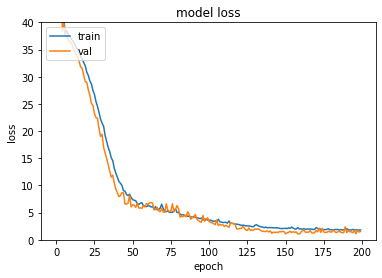

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,40])
plt.show()

In [15]:
keras_predictions = model.predict(x_test, verbose=2)

16/16 - 0s


In [16]:

print("Error on test data simple model")
mse_test_simple = np.mean(np.power(keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_simple) #2.6873526

mae_test_simple = np.mean(np.abs(keras_predictions-y_test.values))
print("MAE: ", mae_test_simple) # 1.12

mape_test_simple = 100*np.mean(np.abs(np.divide(keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_simple, "%") # 3.574



Error on test data simple model
MSE:  32.605900316588325
MAE:  5.405691184312567
MAPE:  19.33360930705985 %


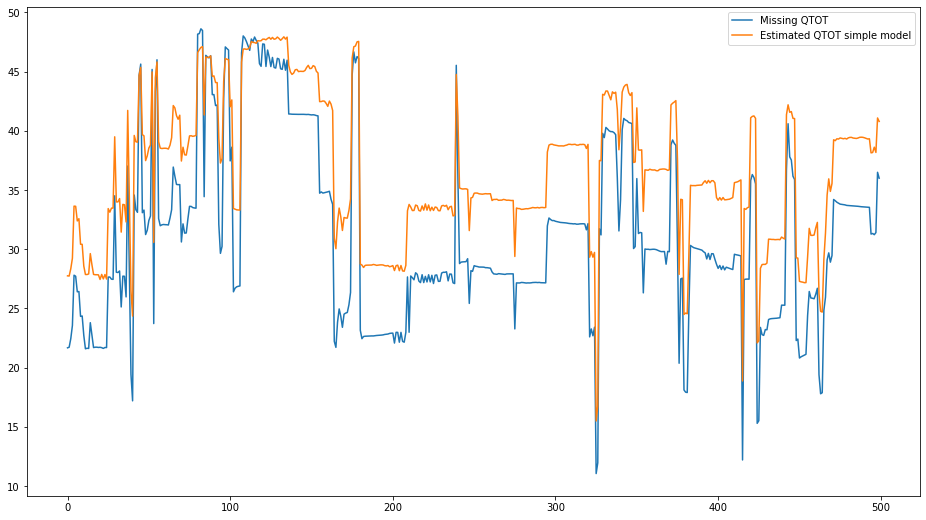

In [17]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.legend()

# Improve model

### Adding a dropout layer

In [18]:
from keras.layers import Dropout

input_layer_size = x_train.columns.size

improved_model = keras.Sequential()
improved_model.add(keras.layers.Dense(input_layer_size, activation='relu', input_shape=(input_layer_size,)))
model.add(keras.layers.Dropout(0.4))
improved_model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dropout(0.4))
improved_model.add(keras.layers.Dense(1))

In [19]:
improved_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________


In [20]:
improved_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Early stopping

In [21]:
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier

callback = EarlyStopping(monitor='val_loss', patience=4)


improved_history = improved_model.fit(x_train,y_train,validation_data=(x_val, y_val),epochs=200, batch_size=10, callbacks=[callback],verbose=2)

Epoch 1/200
23/23 - 0s - loss: 937.4254 - val_loss: 892.4122
Epoch 2/200
23/23 - 0s - loss: 924.6332 - val_loss: 881.6551
Epoch 3/200
23/23 - 0s - loss: 914.6549 - val_loss: 872.3490
Epoch 4/200
23/23 - 0s - loss: 904.7334 - val_loss: 862.0552
Epoch 5/200
23/23 - 0s - loss: 893.4817 - val_loss: 850.2321
Epoch 6/200
23/23 - 0s - loss: 880.5034 - val_loss: 836.6946
Epoch 7/200
23/23 - 0s - loss: 865.5870 - val_loss: 820.8700
Epoch 8/200
23/23 - 0s - loss: 848.1562 - val_loss: 802.8129
Epoch 9/200
23/23 - 0s - loss: 828.3198 - val_loss: 781.7040
Epoch 10/200
23/23 - 0s - loss: 805.2018 - val_loss: 757.8017
Epoch 11/200
23/23 - 0s - loss: 778.8908 - val_loss: 730.0419
Epoch 12/200
23/23 - 0s - loss: 748.8469 - val_loss: 698.8532
Epoch 13/200
23/23 - 0s - loss: 715.0607 - val_loss: 663.7173
Epoch 14/200
23/23 - 0s - loss: 677.1533 - val_loss: 625.2723
Epoch 15/200
23/23 - 0s - loss: 635.8735 - val_loss: 583.4275
Epoch 16/200
23/23 - 0s - loss: 591.1200 - val_loss: 538.6763
Epoch 17/200
23/2

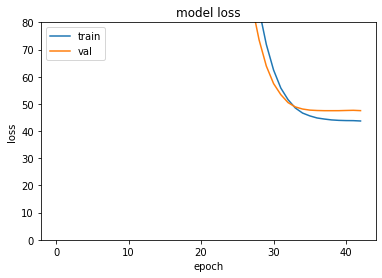

In [22]:
plt.plot(improved_history.history['loss'])
plt.plot(improved_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,80])
plt.show()

In [23]:
improved_keras_predictions = improved_model.predict(x_test, verbose=2)

16/16 - 0s


In [24]:

print("Error on test data improved model")
mse_test_improved = np.mean(np.power(improved_keras_predictions - y_test.values, 2))
print("MSE: ", mse_test_improved) #2.6873526

mae_test_improved = np.mean(np.abs(improved_keras_predictions-y_test.values))
print("MAE: ", mae_test_improved) # 1.12

mape_test_improved = 100*np.mean(np.abs(np.divide(improved_keras_predictions - y_test.values, y_test.values)))
print("MAPE: ", mape_test_improved, "%") # 3.574



Error on test data improved model
MSE:  46.86028480264464
MAE:  5.237911328797708
MAPE:  17.063105902951296 %


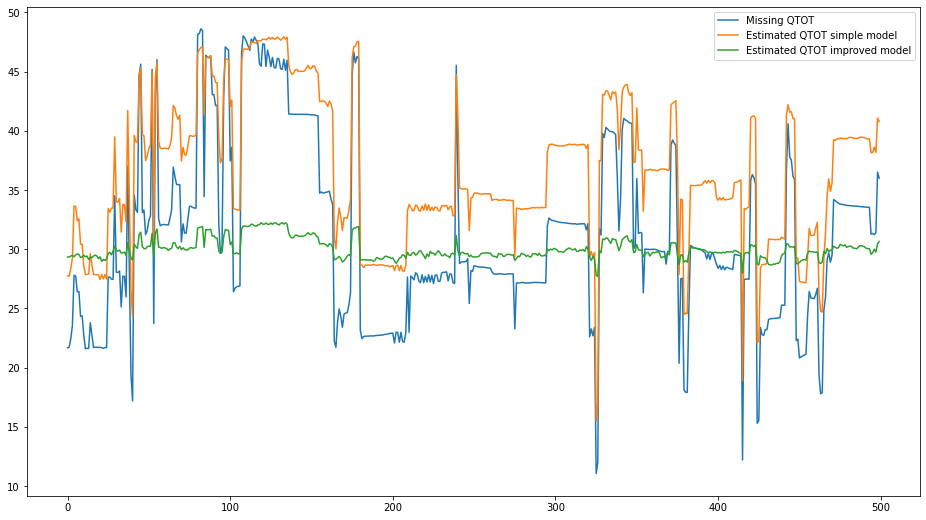

In [25]:
plt.figure(figsize=(16,9))
plt.plot(y_test.values, label='Missing QTOT')
plt.plot(keras_predictions, label='Estimated QTOT simple model')
plt.plot(improved_keras_predictions, label='Estimated QTOT improved model')
plt.legend()

In [26]:
import numpy as np
from tabulate import tabulate

m = np.array([["MSE", mse_test_simple, mse_test_improved],["MAE", mae_test_simple, mae_test_improved ],["MAPE", mape_test_simple, mape_test_improved]]);

headers = ["old", "new"]

table = tabulate(m, headers, tablefmt="fancy_grid")

print(table)


╒══════╤══════════╤══════════╕
│      │      old │      new │
╞══════╪══════════╪══════════╡
│ MSE  │ 32.6059  │ 46.8603  │
├──────┼──────────┼──────────┤
│ MAE  │  5.40569 │  5.23791 │
├──────┼──────────┼──────────┤
│ MAPE │ 19.3336  │ 17.0631  │
╘══════╧══════════╧══════════╛
